# ALeRCE classes

https://github.com/ZwickyTransientFacility/ztf-avro-alert

1. **AGN:** Active Galactic Nuclei
1. **Blazar:** Blazar
1. **CV/Nova:** Cataclysmic Variable Star/Nova
1. **Ceph:** Cepheid Variable Star
1. **DSCT:** Delta Scuti Star
1. **EA:** Eclipsing Algol
1. **EB/EW:** Eclipsing Binaries/Eclipsing W Ursa Majoris
1. **LPV:** Long Period Variable
1. **Periodic-Other:** Periodic-Other
1. **QSO:** Quasi-Stellar Object
1. **RRL:** RRLyrae Variable Star
1. **RSCVn:** RS Canum Venaticorum
1. **SLSN:** Super Luminous Supernova
1. **SNII:** Supernova II
1. **SNIIb:** Supernova IIb
1. **SNIIn:** Supernova IIn
1. **SNIa:** Supernova Ia
1. **SNIbc:** Supernova Ibc
1. **TDE:** Tidal disruption event (to remove)
1. **YSO:** Young Stellar Object
1. **ZZ:** ZZ Ceti Stars (to remove)

In [1]:
import sys
sys.path.append('../../') # or just install the module
sys.path.append('../../../fuzzy-tools') # or just install the module

In [2]:
%load_ext autoreload
%autoreload 2
from lchandler.surveyexport.alerce_utils import process_df_labels, process_df_detections, keep_only_valid_objs
import numpy as np
import pandas as pd

load_rootdir = '../../../surveys-data'
survey_name = 'alerceZTFv7.1'
uses_corr = False # False only can be used with SNe objects
clean_invalid_objs = True # delete a lot of objects
df_index_names = {
    'oid':'oid', # object id
    'oid_det':'objectId', # object id
    'label':'classALeRCE', # object class name
    'ra':'ra',
    'dec':'dec',
    'band':'fid', # band
    'obs_day':'mjd', # days
    'obs':'magpsf_corr' if uses_corr else 'magpsf', # observations
    'obs_error':'sigmapsf_corr' if uses_corr else 'sigmapsf', # observation errors
}
detections_cols = ['objectId', 'fid', 'mjd', df_index_names['obs'], df_index_names['obs_error']]

### load files and processing
detections_df = pd.read_parquet(f'{load_rootdir}/{survey_name}/detections_with_xmatch')
detections_df, det_objs = process_df_detections(detections_df, df_index_names['oid_det'], df_index_names['oid'], detections_cols, uses_corr=uses_corr, clean_invalid_objs=clean_invalid_objs)
print(f'[detections_df] columns={list(detections_df.columns)} - id={detections_df.index.name}')

labels_df = pd.read_csv(f'{load_rootdir}/{survey_name}/dfcrossmatches_prioritized_v7.0.1.csv')
labels_df, label_objs = process_df_labels(labels_df, df_index_names['oid'], det_objs)
print(f'[labels] columns={list(labels_df.columns)} - id={labels_df.index.name}')

outliers_df = pd.read_csv(f'{load_rootdir}/{survey_name}/outliers.csv')

### filter
valid_objs = list(set(det_objs) & set(label_objs))
labels_df = keep_only_valid_objs(labels_df, valid_objs)
detections_df = keep_only_valid_objs(detections_df, valid_objs)

### print info
classes = set(labels_df[df_index_names['label']].values)
print('classes:', classes)

../../lchandler/surveyexport/alerce_utils.py:83: UserWarning: only use uses_corr=False with SNe objects
  warnings.warn('only use uses_corr=False with SNe objects')


[detections_df] columns=['fid', 'mjd', 'magpsf', 'sigmapsf'] - id=oid
[labels] columns=['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec'] - id=oid
classes: {'Periodic-Other', 'EA', 'QSO', 'YSO', 'SNII', 'TDE', 'NLQSO', 'RRL', 'DSCT', 'CV/Nova', 'ZZ', 'EB/EW', 'RSCVn', 'AGN', 'Blazar', 'SNIbc', 'LPV', 'SNIIb', 'Ceph', 'SNIa', 'NLAGN', 'SNIIn', 'SLSN'}


In [3]:
detections_df.info()
detections_df[:10]

<class 'pandas.core.frame.DataFrame'>
Index: 1032591 entries, ZTF18aavejan to ZTF20abcxmfu
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   fid       1032591 non-null  int64  
 1   mjd       1032591 non-null  float64
 2   magpsf    1032591 non-null  float32
 3   sigmapsf  1032591 non-null  float32
dtypes: float32(2), float64(1), int64(1)
memory usage: 31.5+ MB


,fid,mjd,magpsf,sigmapsf
oid,,,,
ZTF18aavejan,1,58307.352859,19.103745,0.150523
ZTF18aavejan,1,58812.120914,18.976879,0.154910
ZTF18aavejan,1,58376.211956,19.124577,0.131040
ZTF18aavejan,1,58812.111169,19.083048,0.168238
ZTF18aavejan,1,59038.288241,19.032909,0.166986
ZTF18aavejan,1,58612.413391,19.403605,0.178850
ZTF18aavejan,1,58377.257118,18.993353,0.135941
ZTF18aavejan,1,58776.122396,19.255226,0.119648
ZTF18aavejan,1,58429.170671,19.151890,0.176973


In [4]:
labels_df.info()
labels_df[:10]

<class 'pandas.core.frame.DataFrame'>
Index: 18694 entries, ZTF19aapcxhy to ZTF18acbvwsq
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   classALeRCE        18694 non-null  object 
 1   ra                 18694 non-null  float64
 2   dec                18694 non-null  float64
 3   period             988 non-null    object 
 4   source             18694 non-null  object 
 5   id_source          18694 non-null  object 
 6   class_source       18694 non-null  object 
 7   separation_arcsec  18694 non-null  float64
dtypes: float64(3), object(5)
memory usage: 1.3+ MB


,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
oid,,,,,,,,
ZTF19aapcxhy,AGN,154.202129,18.723076,NaN,Oh2015,5.877420127343739e+17,AGN_galaxy_dominated,0.227455
ZTF18abwtbad,AGN,51.846346,0.739559,NaN,Oh2015,5.877315136939624e+17,AGN_galaxy_dominated,0.084636
ZTF18acvgdfy,AGN,134.407409,5.472596,NaN,Oh2015,5.877327033915148e+17,AGN_galaxy_dominated,0.087190
ZTF18aadyxlg,AGN,125.577004,33.091120,NaN,Oh2015,5.880133827239608e+17,AGN_galaxy_dominated,0.073570
ZTF19aapuscr,AGN,199.102327,-2.090396,NaN,Oh2015,5.87724649802236e+17,AGN_galaxy_dominated,0.038667
ZTF19aanxuxz,AGN,212.636953,-2.822530,NaN,Oh2015,5.877297769066006e+17,AGN_galaxy_dominated,0.181073
ZTF19aaohxwd,AGN,175.347895,21.936834,NaN,Oh2015,5.877420610690746e+17,AGN_galaxy_dominated,0.150095
ZTF19aansigk,AGN,177.519279,21.042260,NaN,Oh2015,5.880236707797402e+17,AGN_galaxy_dominated,0.160927
ZTF18aceqjzp,AGN,139.303760,37.075558,NaN,Oh2015,5.882978641805313e+17,AGN_galaxy_dominated,0.456351


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


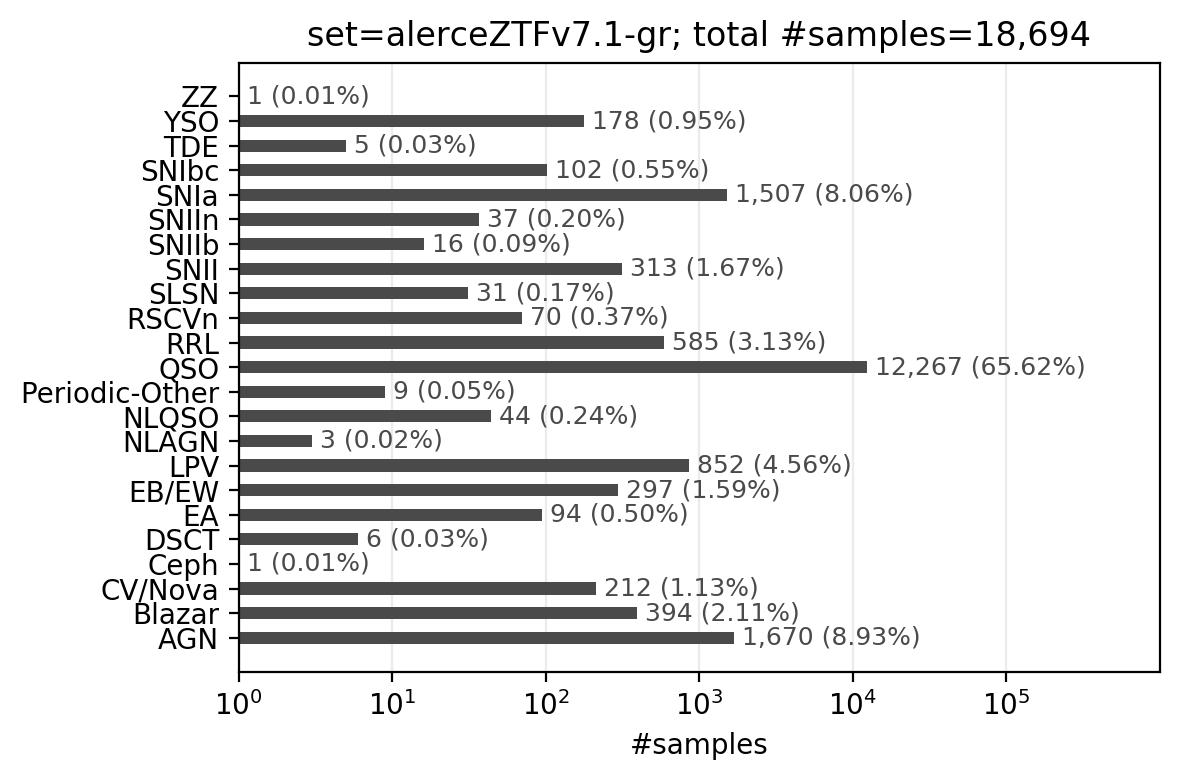

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lchandler.surveyexport.dictionary_creator import LightCurveDictionaryCreator

band_dictionary = {
    'g':1,
    'r':2,
}
lcDictionaryCreator = LightCurveDictionaryCreator(survey_name, detections_df, labels_df, band_dictionary, df_index_names,
    dataframe_obs_uses_flux=False,
    zero_point=48.6,
    )
#print(lcDictionaryCreator)
lcDictionaryCreator.plot_class_distribution(uses_log_scale=1)

In [6]:
l = lcDictionaryCreator.get_obj_names('SNIIb')
print(f'{l} ({len(l)}#)')

['ZTF18abojpnr', 'ZTF19aaugupw', 'ZTF19aawethv', 'ZTF18acbzoyh', 'ZTF18acqxyiq', 'ZTF18acrcyqw', 'ZTF19aadpqnb', 'ZTF19aaknate', 'ZTF19aalzvnu', 'ZTF19abqykei', 'ZTF19abqmsnk', 'ZTF19acyjjni', 'ZTF19aczmnqy', 'ZTF19aaejtof', 'ZTF20aawefgx', 'ZTF20aaxhzhc'] (16#)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


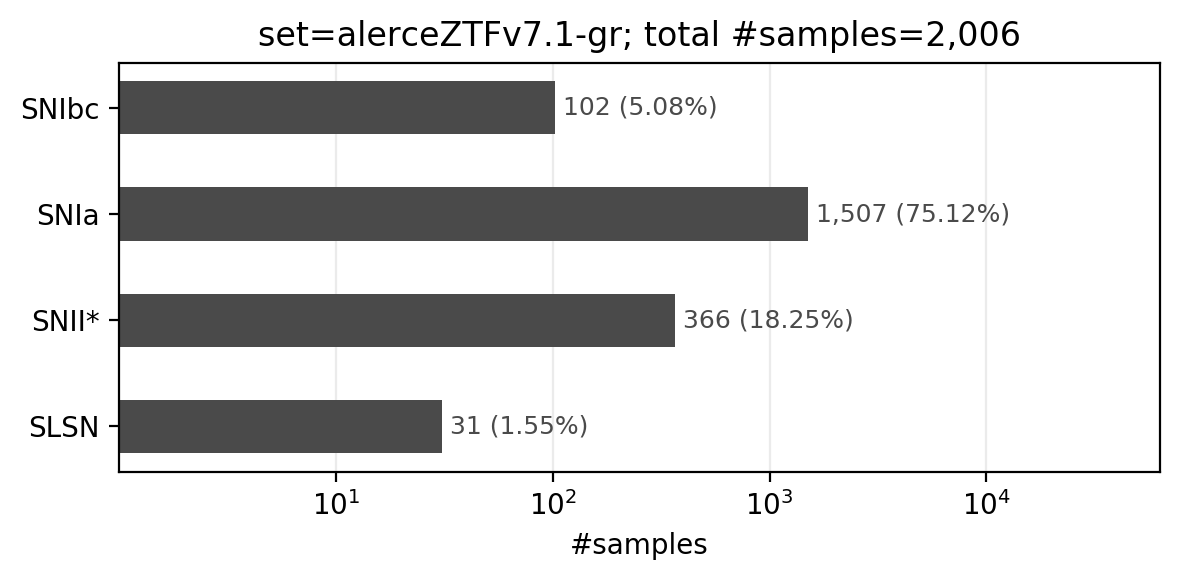

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
DF_SN_LIST = ['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIa', 'SNIbc']

#mode = 'raw'
#mode = 'simple'
#mode = 'transients'
#mode = 'RRCeph'
mode = 'onlySNe'
#mode = 'onlySNe-SLSN'

if mode=='simple':
    invalid_classes = []
    query_classes = []
    to_merge_classes_dic = {'SN':DF_SN_LIST,}
    
elif mode=='onlySNe':
    kwargs = {
        'invalid_classes':[],
        'query_classes':DF_SN_LIST,
        'merge_classes_dict':{
            'SNII*':['SNII', 'SNIIb', 'SNIIn'],
        },
    }
elif mode=='onlySNe-SLSN':
    kwargs = {
        'invalid_classes':[],
        'query_classes':[sn for sn in DF_SN_LIST if not sn=='SLSN'],
        'merge_classes_dict':{
            'SNII*':['SNII', 'SNIIb', 'SNIIn'],
        },
    }

elif mode=='onlySNIa':
    kwargs = {
        'invalid_classes':[],
        'query_classes':DF_SN_LIST,
        'merge_classes_dict':{
            'non-SNIa':['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIbc'],
        },
    }

elif mode=='RRCeph':
    invalid_classes = []
    query_classes = ['RRL','Ceph']
    to_merge_classes_dic = {}

lcDictionaryCreator.update_labels_df(**kwargs)
lcDictionaryCreator.plot_class_distribution(
    figsize=(6,3),
    uses_log_scale=1,
    )
#assert 0

In [8]:
%load_ext autoreload
%autoreload 2

description = 'ZTF Alerce'
save_folder = f'../../../surveys-save'
lcdataset = lcDictionaryCreator.export_dictionary(description, save_folder,
    band_names=list(band_dictionary.keys()),
    #to_export_bands=['g','r'],
    filename_extra_parameters={'mode':mode},
    outliers_df=outliers_df,
    #saves_dict=True,
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
band_names=['g', 'r']
cleaning the DataFrame; samples=1,032,591


  0%|          | 2/2006 [00:00, 258.11it/s, obj=ZTF18aacdbzx; y=3; c=SNIbc; lengths_bdict={'g': 5, 'r': 6}; correct_samples=3 (any-band>=5)]

remove_invalid_bands > samples=1,032,562
remove_invalid_classes > samples=63,354
remove_negative_obs > samples=63,354
save_filedir=../../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds
easy_label_dict={'SLSN': 0, 'SNII*': 1, 'SNIa': 2, 'SNIbc': 3}


100%|██████████| 2006/2006 [00:08, 238.35it/s, obj=ZTF20abhvnzc; y=2; c=SNIa; lengths_bdict={'g': 8, 'r': 10}; correct_samples=1,998 (any-band>=5)]   

total_obs=63354; removed_obs=8332; new_total_obs=55022; %=13.151


In [9]:
print(lcdataset)

LCDataset:
[outliers; samples 4]
(.) obs_samples=289; min_len=14; max_dur=408.0[days]; dur(p50)=222.1[days]; cadence(p50)=0.9[days]
(g) obs_samples=144; min_len=6; tmax=44.923828125; max_dur=408.0 [days]; dur(p50)=222.0 [days]; cadence(p50)=1.9 [days]
(r) obs_samples=145; min_len=8; tmax=212.09375; max_dur=376.0 [days]; dur(p50)=220.4 [days]; cadence(p50)=2.0 [days]
   |██      | SLSN - 1/4 (25.00%)
   |████    | SNII* - 2/4 (50.00%)
   |██      | SNIa - 1/4 (25.00%)
   |        | SNIbc - 0/4 (0.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,994]
(.) obs_samples=54,685; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,132; min_len=0; tmax=10.99609375; max_dur=538.8 [days]; dur(p50)=39.0 [days]; cadence(p50)=3.0 [days]
(r) obs_samples=30,

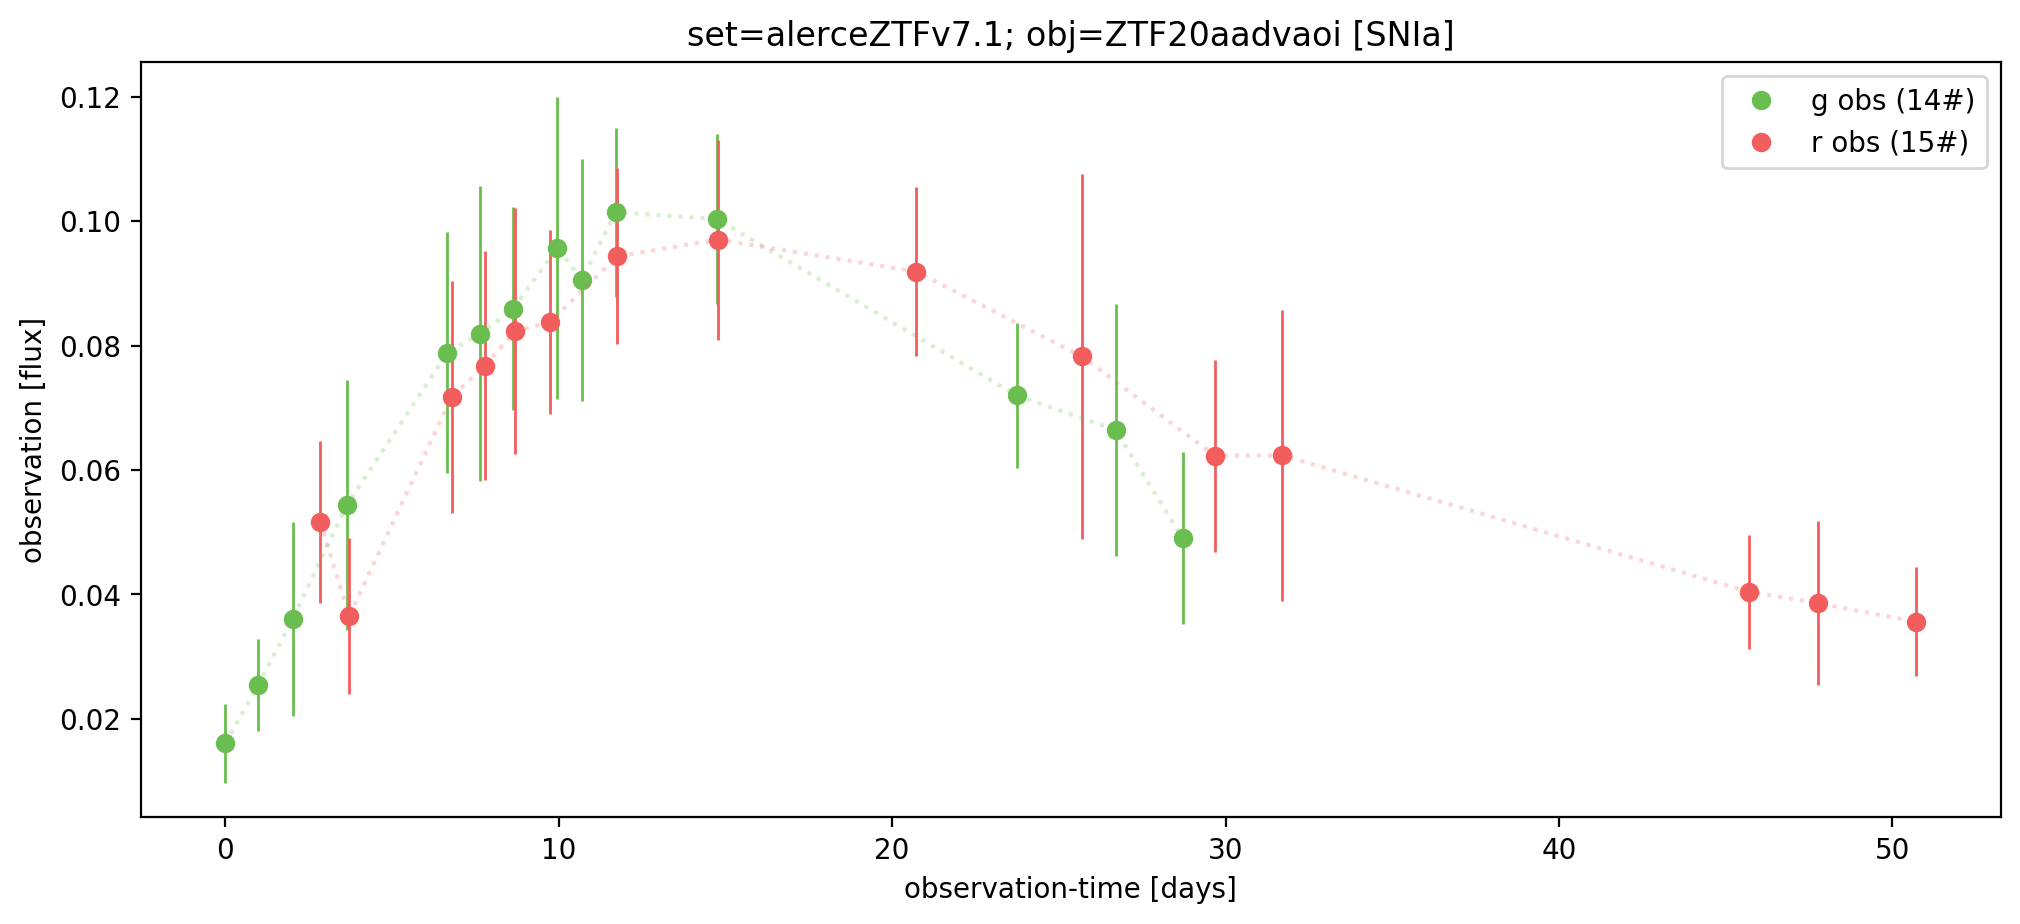

In [10]:
import fuzzytools.lists as lists
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve

lcset = lcdataset['raw']
lcobj, lcobj_name = lcset.get_random_lcobj()
lcobj_name = 'ZTF20aadvaoi'
lcobj = lcset[lcobj_name].copy()
figsize = (12,5)
dpi = 200
fig, ax = plt.subplots(1,1, figsize=figsize, dpi=dpi)
for kb,b in enumerate(lcset.band_names):
    plot_lightcurve(ax, lcobj, b, f'{b} obs')
ax.set_title(f'set={lcset.survey}; obj={lcobj_name} [{lcset.class_names[lcobj.y]}]')
ax.set_xlabel('observation-time [days]')
ax.set_ylabel('observation [flux]')
ax.legend()
ax.grid(alpha=0.0)